# DynMod, Problem solutions

#### Bernt Lie, University College of Southeast Norway

### Basic import and definitions

In [1]:
from OMPython import ModelicaSystem
import numpy as np
import numpy.random as nr
%matplotlib inline
%config InlineBackend.figure_formats={'svg',}  # use high quality SVG instead of PNGs
import matplotlib.pyplot as plt
import pandas as pd
LW1 = 2.5
LW2 = LW1/2
Cb1 = (0.3,0.3,1)
Cb2 = (0.7,0.7,1)
Cg1 = (0,0.6,0)
Cg2 = (0.5,0.8,0.5)
Cr1 = "Red"
Cr2 = (1,0.5,0.5)
LS1 = "solid"
LS2 = "dotted"
#### 
createPDF = False  # set to 'True' if you want to save plots as PDFs in addition
if createPDF:
    %mkdir figs
    figpath = "../figs/"
####
case = "ProblemSolutionsCases"
####
%mkdir $case # create a subfolder for this case
%cd $case

/home/dietmarw/.workspace/FM1015/ProblemSolutionsCases


### Controlled reactor, species balance

#### Modelica code, file SpeciesControlledReactor

In [2]:
%%writefile SpeciesControlledReactor.mo
package SpeciesControlledReactor
  // Package for simulating controlled reactor
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			May 15, 2017
  //
  model ModControlledReactor
    // Model of controlled reactor, problems for species balance
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			May 15, 2017
	//
	// Constants
	constant Real g = 9.81 "Acceleration of gravity, m/s2";
	// Parameters
	parameter Real A = 10 "Vessel surface area, m2";
	parameter Real k = 1 "Reaction rate constant, 1/h";
	parameter Real KvA = 1 "Species A feed valve constant";
	parameter Real Kve = KvA "Effluent valve constant";
	parameter Real pA = 3 "Feed pressure species A, bar";
	parameter Real pa = 1 "Atmospheric pressure, bar";
	parameter Real rho = 1e3 "Density of liquid, kg/L";
	parameter Real Kc = 100 "Concentration controller gain";
	parameter Real KL = Kc "Level controller gain";	
	parameter Real ucs = 0 "steady state concentration control input";
	parameter Real uLs = 0 "steady state level control input";
	// Controller referance values
	parameter Real hr = 2 "Level reference, m";
	parameter Real cAr = 1e-2 "Concentration reference for species A, mol/m3";
	// Initial state parameters
	parameter Real h0 = 2.11 "Initial level, m";
	parameter Real cA0 = 1.5e-2 "Initial concentration of A, mol/m3";
	// Declaring variables
	// -- states
	Real h(start=h0,fixed=true);
	Real cA(start=cA0,fixed=true);
	Real VdiA "Influent flow rate of species A, m3/h";
	Real Vde "Effluent flow rate, m3/h";
	Real uc "Concentration control input";
	Real uL "Level control input";
	// -- input flow
	Real Vdic = 50 "Influent flow of water/catalyst, m3/h";
	Real cAi "Influent concentration of A, mol/m3";
  // Equations constituting the model
  equation
	// Concentration input
	cAi = if time < 1 then 5 else 2;
	// Controllers
	uc = max(0,ucs + Kc*(cAr-cA));
	uL = max(0,uLs + KL*(h-hr));
	// Valves
	VdiA = KvA*sqrt((pA-pa)/rho);
	Vde = Kve*uL*sqrt(g*h);
	// Differential equations
	der(h) = (Vdic+VdiA-Vde)/A;
	der(cA) = VdiA*cAi/(A*h) - (VdiA+Vdic)*cA/(A*h) - k*cA;
  end ModControlledReactor;
  // End package
end SpeciesControlledReactor;

Writing SpeciesControlledReactor.mo


#### Instantiating model from ModControlledReactor

In [3]:
cr = ModelicaSystem("SpeciesControlledReactor.mo","SpeciesControlledReactor.ModControlledReactor")

2017-08-09 10:58:12,869 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.670b8d4d7172451c83b48254d19a8ffc


In [4]:
cr.setSimulationOptions(stopTime=3,stepSize=1e-2)

In [5]:
cr.simulate()

In [6]:
tm,h,cA = cr.getSolutions("time","h","cA")

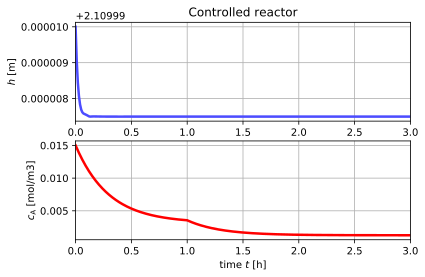

In [7]:
plt.subplot(2,1,1)
plt.plot(tm,h,linewidth=LW1,color=Cb1,label=r"$h$")
plt.title(r"Controlled reactor")
plt.ylabel(r"$h$ [m]")
plt.grid()
plt.xlim(0,3)
plt.subplot(2,1,2)
plt.plot(tm,cA,linewidth=LW1,color=Cr1,label=r"$c_\mathrm{A}$")
plt.xlabel(r"time $t$ [h]")
plt.ylabel(r"$c_\mathrm{A}$ [mol/m3]")
plt.grid()
plt.xlim(0,3)
if createPDF:
    figfile = "controlledReactorSim.pdf"
    plt.savefig(figpath+figfile)
    plt.savefig(figpath+"controlledReactorSim.svg")

### Controlled water pumping, momentum balance

#### Modelica code, file MomentumWaterPump

In [8]:
%%writefile MomentumWaterPump.mo
package MomentumWaterPump
  // Package for simulating water pump system
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			May 15, 2017
  //
  model ModWaterPump
    // Model of water pump system, problems for momentum balance
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			May 15, 2017
	//
	// Parameters
	parameter Real A = 10 "Cross sectional area of vessel, m2";
	parameter Real Ap = 1e-2 "cross sectional area of pipe, m2";
	parameter Real mp = 10 "Mass of liquid in pipe, tonne";
	parameter Real kappa_p = 1e2*3600^2 "Conversion from bar to tonne-based pressure";
	parameter Real c = 8e-6*kappa_p "Friction coefficient, bar.h2/m4";
	parameter Real c1 = 3e-4*kappa_p "Constant in pump characteristic, bar";
	parameter Real c2 = 4e-8*kappa_p "Constant in pump characteristic, bar.h2/m6";
	parameter Real Kp = 100 "Proportional gain in controller, 1/m";
	parameter Real us = 0 "Constant offset in controller";
	// Controller referance value
	parameter Real hr = 2 "Level reference, m";
	// Initial state parameters
	parameter Real h0 = 1.9 "Initial level, m";
	parameter Real Vdi0 = 2 "Influent flow rate, m3/h";
	// Declaring variables
	// -- states
	Real h(start=h0,fixed=true);
	Real Vdi(start=Vdi0,fixed=true);
	// -- disturbance flow
	Real Vde "Effluent flow rate, m3/h";
	// -- algebraic variables
	Real dp "Pump differential presure, bar";
	Real Ff "Pipe friction force, N";
	// -- control signal
	Real u "Level control input";
  // Equations constituting the model
  equation
	// Effluent flow disturbance
	Vde = if time < 2 then 2 else 2-0.5;
	// Controller
	u = max(0,us + Kp*(hr-h));
	// Pump differential pressure
	dp = u*(c1-c2*Vdi^2);
	// Friction force
	Ff = c*Vdi^2;
	// Differential equations
	der(h) = (Vdi - Vde)/A;
	der(Vdi) = Ap*(Ap*dp-Ff)/mp;
  end ModWaterPump;
  // End package
end MomentumWaterPump;

Writing MomentumWaterPump.mo


#### Instantiating model from ModWaterPump

In [9]:
wp = ModelicaSystem("MomentumWaterPump.mo","MomentumWaterPump.ModWaterPump")

2017-08-09 10:58:15,633 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.af91964c7cd640aca5f7cf481d470350


In [10]:
wp.setSimulationOptions(stopTime=5,stepSize=1e-2)

In [11]:
wp.simulate()

In [12]:
tm,h,Vdi = wp.getSolutions("time","h","Vdi")

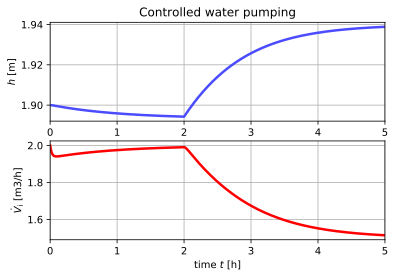

In [13]:
plt.subplot(2,1,1)
plt.plot(tm,h,linewidth=LW1,color=Cb1,label=r"$h$")
plt.title(r"Controlled water pumping")
plt.ylabel(r"$h$ [m]")
plt.grid()
plt.xlim(0,5)
plt.subplot(2,1,2)
plt.plot(tm,Vdi,linewidth=LW1,color=Cr1,label=r"$\dot{V}_\mathrm{i}$")
plt.xlabel(r"time $t$ [h]")
plt.ylabel(r"$\dot{V}_\mathrm{i}$ [m3/h]")
plt.grid()
plt.xlim(0,5)
if createPDF:
    figfile = "WaterPumpSystemSim.pdf"
    plt.savefig(figpath+figfile)
    plt.savefig(figpath+"WaterPumpSystemSim.svg")

### Controlled heated tank with varying liquid level

#### Modelica code, file EnergyHeatedTank

In [14]:
%%writefile EnergyHeatedTank.mo
package EnergyHeatedTank
  // Package for simulating heated tank with varying liquid level
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			May 15, 2017
  //
  model ModHeatedTank
    // Model of heated tank with varying liquid level
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			May 15, 2017
	//
	// Constants
	constant Real g = 9.81 "Acceleration of gravity, m/s2";
	constant Real PI = 3.141592654 "Math constant PI";
	// Parameters
	parameter Real A = 10 "Cross sectional area of vessel, m2";
	parameter Real D = 0.5 "Diameter of heat element, m";
	parameter Real A1 = A-PI*D^2/4 "Effective cross sectional area, m2";
	parameter Real Kv = 1 "Valve constant, m3/h";
	parameter Real rho = 1e3 "Density of liquid, kg/m3";
	parameter Real kappa_p = 1.01e5 "Conversion factor, bar to Pa";
	parameter Real pa = 1*kappa_p "Atmospheric pressure, bar";
	parameter Real Uh = 3e3 "Overall heat transfer coefficient, J/(K.m2.h)";
	parameter Real cp = 4200 "Specific heat capacity of liquid, J/kg/K";
	parameter Real us = 0 "Fixed controller offset";
	parameter Real Kp = 1 "Controller proportional gain, 1/m";
	// Initial state parameters
	parameter Real h0 = 2 "Initial level, m";
	parameter Real T0 = 350 "Initial temperature, K";
	// Variables
	// -- states
	Real h(start=h0,fixed=true) "Level in tank, m";
	Real T(start=T0,fixed=true) "Temperature in tank, K";
	// -- reference value
	Real hr = 2 "Reference value for level, m";
	// -- inputs
	Real Vdi = 50 "Influent volumetric flow, m3/h";
	Real Vde "Effluent volumetric flow rate, m3/h";
	Real Ti = 300 "Influent temperature, K";
	Real Th = 450 "Heat element temperature, K";
		Real u "Level control input";
  // Equations constituting the model
  equation
	// Algebraic equations
	Vde = Kv*u*sqrt(rho*g*h/pa);
	u = us - Kp*(hr-h);
	// Differential equations
	der(h) = (Vdi - Vde)/A1;
	der(T) = Vdi*(Ti-T)/(A1*h) + Uh*PI*D*(Th-T)/(rho*cp*A1);
  end ModHeatedTank;
  // End package
end EnergyHeatedTank;

Writing EnergyHeatedTank.mo


#### Instantiating model from ModHeatedTank

In [15]:
ht = ModelicaSystem("EnergyHeatedTank.mo","EnergyHeatedTank.ModHeatedTank")

2017-08-09 10:58:18,218 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.0b0659b46e0748f9b626a37970e8cff9


In [16]:
ht.setSimulationOptions(stopTime=15,stepSize=3e-2)

In [17]:
ht.simulate()

In [18]:
tm,h,T = ht.getSolutions("time","h","T")

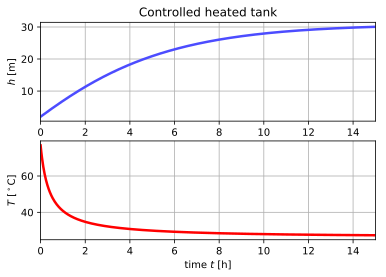

In [19]:
plt.subplot(2,1,1)
plt.plot(tm,h,linewidth=LW1,color=Cb1,label=r"$h$")
plt.title(r"Controlled heated tank")
plt.ylabel(r"$h$ [m]")
plt.grid()
plt.xlim(0,15)
plt.subplot(2,1,2)
plt.plot(tm,T-273.15,linewidth=LW1,color=Cr1,label=r"$T$")
plt.xlabel(r"time $t$ [h]")
plt.ylabel(r"$T$ [${}^\circ$C]")
plt.grid()
plt.xlim(0,15)
if createPDF:
    figfile = "heatedWaterLevelDependentSim.pdf"
    plt.savefig(figpath+figfile)
    plt.savefig(figpath+"heatedWaterLevelDependentSim.svg")

### Analysis of reactor with heat exchanger

#### Modelica code, file AnalysisReactorHeatExchanger

In [20]:
%%writefile AnalysisReactorHeatExchanger.mo
package AnalysisReactorHeatExchanger
  // Package for analysis of reactor with heat exchanger
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			May 15, 2017
  //
  model SimReactorHeatExchanger
    // Simulation of AnalysisReactorHeatExchanger
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			May 15, 2017
	//
  ModReactorHeatExchanger mcn, mcu, mcd, mcu3, mcu4, mcu5;
  Real Vdc_n, Vdc_u, Vdc_d, Vdc_u3, Vdc_u4, Vdc_u5;
  Real cA_n, cA_u, cA_d, cA_u3, cA_u4, cA_u5;
  Real T_n, T_u, T_d, T_u3, T_u4, T_u5;
  equation
    Vdc_n = 100;
	Vdc_u = if time < 1 then Vdc_n else Vdc_n*1.1;
	Vdc_d = if time < 1 then Vdc_n else Vdc_n*0.9;
	Vdc_u3 = if time < 1 then Vdc_n else Vdc_n*1.13;
	Vdc_u4 = if time < 1 then Vdc_n else Vdc_n*1.14;
	Vdc_u5 = if time < 1 then Vdc_n else Vdc_n*1.15;
	//
	mcn.Vdc = Vdc_n;
	mcu.Vdc = Vdc_u;
	mcd.Vdc = Vdc_d;
	mcu3.Vdc = Vdc_u3;
	mcu4.Vdc = Vdc_u4;
	mcu5.Vdc = Vdc_u5;
	//
	cA_n = mcn.cA;
	cA_u = mcu.cA;
	cA_d = mcd.cA;
	T_n = mcn.T;
	T_u = mcu.T;
	T_d = mcd.T;
	//
	cA_u3 = mcu3.cA;
	cA_u4 = mcu4.cA;
	cA_u5 = mcu5.cA;
	T_u3 = mcu3.T;
	T_u4 = mcu4.T;
	T_u5 = mcu5.T;
  end SimReactorHeatExchanger;
  //
  model ModReactorHeatExchanger
    // Model of AnalysisReactorHeatExchanger
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			May 15, 2017
	//
	// Parameters
	parameter Real V = 100. "Vessel volume, L";
	parameter Real rho = 1.e3 "Liquid density, g/L";
	parameter Real rhoc = rho "Coolant liquid density, g/L";
	parameter Real cp = 1. "Liquid specific heat capacity, cal/(g.K)";
	parameter Real cpc = cp "Coolant liquid specific heat capacity, cal/(g.K)";
	parameter Real k0 = 7.2e10 "Reaction pre-exponential factor, 1/min";
	parameter Real EdR = 9.98e3 "Reaction activation 'temperature', K";
	parameter Real m = 1 "Reaction order,-";
	parameter Real dHr = -2.e5 "Reaction enthalpy, cal/mol";
	parameter Real UOmL = 7.e5 "Heat transfer coefficient, cal/(min.K)";
	// Initial state parameters
	parameter Real cA0 = 8.235e-2 "Initial concentration, mol/L";
	parameter Real T0 = 441.81 "Initial temperature, K";
	// Variables
	// -- differential variables
	Real cA(start=cA0, fixed=true) "Concentration, mol/L";
	Real T(start=T0, fixed=true) "Temperature, K";
	// -- auxiliary variables
	Real r "Reaction rate";
	Real Qd "Heat rate";
	// -- fixed input
	Real Vd = 100. "Volumetric through-flow, L/min";
	Real cAi = 1. "Influent concentration of A, mol/L";
	Real Ti = 350. "Influent temperature, K";
	Real Tci = 350. "Influent temperature, K";
	// External input
	input Real Vdc "Coolant flow rate, L/min";
  // Equations constituting the model
  equation
	// Algebraic equations
	r = k0*exp(-EdR/T)*cA^m;
	Qd = Vdc*rhoc*cpc*(1-exp(-UOmL/(rhoc*cpc*Vdc)))*(Tci-T);
	// Differential equations
	der(cA) = Vd*(cAi-cA)/V-m*r;
	der(T) = Vd*(Ti-T)/V + (-dHr)*r/(rho*cp) + Qd/(rho*V*cp);
  end ModReactorHeatExchanger;
  // End package
end AnalysisReactorHeatExchanger;

Writing AnalysisReactorHeatExchanger.mo


#### Instantiating model from SimReactorHeatExchanger

In [21]:
rx = ModelicaSystem("AnalysisReactorHeatExchanger.mo","AnalysisReactorHeatExchanger.SimReactorHeatExchanger")

2017-08-09 10:58:20,904 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.623d213124f5475eb962bb8e77ee51fd


In [22]:
rx.setSimulationOptions(stopTime=8,stepSize=2e-2)

In [23]:
rx.simulate()

In [24]:
tm,cAn,cAu,cAd,Tn,Tu,Td = rx.getSolutions("time","cA_n","cA_u","cA_d","T_n","T_u","T_d")

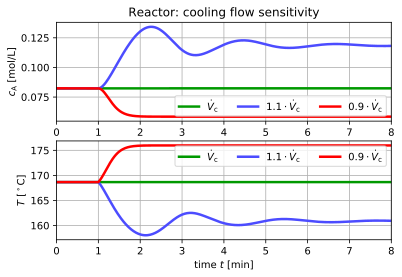

In [25]:
plt.subplot(2,1,1)
plt.plot(tm,cAn,linewidth=LW1,color=Cg1,label=r"$\dot{V}_\mathrm{c}$")
plt.plot(tm,cAu,linewidth=LW1,color=Cb1,label=r"$1.1\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,cAd,linewidth=LW1,color=Cr1,label=r"$0.9\cdot \dot{V}_\mathrm{c}$")
plt.title(r"Reactor: cooling flow sensitivity")
plt.ylabel(r"$c_\mathrm{A}$ [mol/L]")
plt.grid()
plt.legend(ncol=3)
plt.xlim(0,8)
plt.subplot(2,1,2)
plt.plot(tm,Tn-273.15,linewidth=LW1,color=Cg1,label=r"$\dot{V}_\mathrm{c}$")
plt.plot(tm,Tu-273.15,linewidth=LW1,color=Cb1,label=r"$1.1\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,Td-273.15,linewidth=LW1,color=Cr1,label=r"$0.9\cdot \dot{V}_\mathrm{c}$")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"$T$ [${}^\circ$C]")
plt.grid()
plt.legend(ncol=3)
plt.xlim(0,8)
if createPDF:
    figfile = "distributedCoolingReactorAnal.pdf"
    plt.savefig(figpath+figfile)

In [26]:
cAu3,cAu4,cAu5,Tu3,Tu4,Tu5 = rx.getSolutions("cA_u3","cA_u4","cA_u5","T_u3","T_u4","T_u5")

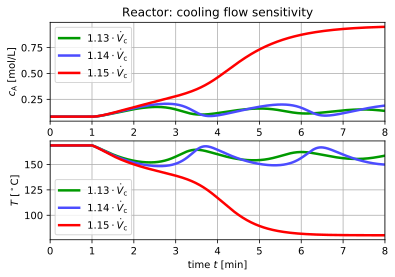

In [27]:
plt.subplot(2,1,1)
plt.plot(tm,cAu3,linewidth=LW1,color=Cg1,label=r"$1.13\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,cAu4,linewidth=LW1,color=Cb1,label=r"$1.14\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,cAu5,linewidth=LW1,color=Cr1,label=r"$1.15\cdot \dot{V}_\mathrm{c}$")
plt.title(r"Reactor: cooling flow sensitivity")
plt.ylabel(r"$c_\mathrm{A}$ [mol/L]")
plt.grid()
plt.legend()
plt.xlim(0,8)
plt.subplot(2,1,2)
plt.plot(tm,Tu3-273.15,linewidth=LW1,color=Cg1,label=r"$1.13\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,Tu4-273.15,linewidth=LW1,color=Cb1,label=r"$1.14\cdot \dot{V}_\mathrm{c}$")
plt.plot(tm,Tu5-273.15,linewidth=LW1,color=Cr1,label=r"$1.15\cdot \dot{V}_\mathrm{c}$")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"$T$ [${}^\circ$C]")
plt.grid()
plt.legend()
plt.xlim(0,8)
if createPDF:
    figfile = "distributedCoolingReactorSensitivity.pdf"
    plt.savefig(figpath+figfile)